In [1]:
    import pandas as pd
    import numpy as np
    import seaborn as sns

    import warnings
    warnings.filterwarnings('ignore')

    import matplotlib.pyplot as plt
    import seaborn as sns

In [3]:
LE_df = pd.read_csv("data/train_df_label_encoded.csv")
OHE_df = pd.read_csv("data/train_df_OHE_encoded.csv")

In [2]:
def feature_Wrapper_RFE(X_train,y_train,model,n_features):    
    #Import your necessary dependencies
    from sklearn.feature_selection import RFE
    #You will use RFE with the  classifier/regressor to select the top n_features.

    #Feature extraction
    rfe = RFE(model, n_features)
    fit = rfe.fit(X_train, y_train)

    print("Num Features: %s" % (fit.n_features_))
    print("Selected Features: %s" % (fit.support_))
    print("Feature Ranking: %s" % (fit.ranking_))

    return X_train.columns[fit.support_]


In [4]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=500)

#
from sklearn.ensemble import RandomForestRegressor ,ExtraTreesRegressor
from sklearn.linear_model import Lasso,LinearRegression
from sklearn.metrics import  mean_absolute_error,r2_score,mean_squared_error
las_R = Lasso()
L_R = LinearRegression()
rf = RandomForestRegressor(n_estimators=200)
et= ExtraTreesRegressor(n_estimators=200)
from sklearn.tree import DecisionTreeRegressor
D_R = DecisionTreeRegressor()
# 
#from sklearn.metrics import SCORERS
#SCORERS.keys()

classifier_list= [rf,et,L_R,las_R,D_R]
classifier_name =['rf','et','L_R','las_R','D_R']
scoring ='neg_root_mean_squared_error'

In [5]:
def run(df,target,model,fold,dropped,save_fold_csv=False):
    from sklearn import model_selection
    from sklearn import metrics ; from sklearn import preprocessing ; from sklearn import impute
    # we create a new column called kfold and fill it with -1
    df["kfold"] = -1
    # the next step is to randomize the rows of the data
    df = df.sample(frac=1).reset_index(drop=True)
    # fetch labels
    y = df[target].values
    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=5)

    for f, (t_, v_) in enumerate(kf.split(X=df, y=y)): # f= fold, t_=train_index ,v_= valid_index
        df.loc[v_, 'kfold'] = f

    #save the new csv with kfold column
    #if save_fold_csv == True:
        #df.to_csv("../input/cat_train_folds.csv", index=False)
    # load the full training data with folds
    # df = pd.read_csv("../input/adult_folds.csv")
    #drop unwanted columns
    df = df.drop(dropped,axis=1)
    
    features = [f for f in df.columns if f not in ("kfold",target)]
    num_col =  [f for f in df.select_dtypes(exclude='object').columns if f not in ("kfold",target)]
    #1. fill all NaN values with NONE
    cat_col = df.select_dtypes(include='object').columns
    for col in cat_col:
    # do not encode the numerical columns
        df.loc[:, col] = df[col].astype(str).fillna("NONE")
        
    #3. fill all NaN values with median
    for col in num_col: 
        imputer = df[col].median()
        df.loc[:, col] = df[col].fillna(imputer)

    #2. label encode the features
    for col in cat_col: 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(df[col])
        df.loc[:, col] = lbl.transform(df[col])
    # get training data using folds
    df_train = df[df.kfold != fold].reset_index(drop=True)
    # get validation data using folds
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    # get training data
    x_train = df_train[features].values
    # get validation data
    x_valid = df_valid[features].values
    # fit model on training data (ohe)
    model.fit(x_train, df_train[target].values)
    # predict on validation data
    # we may need the probability values as we are calculating AUC
    # we will use the probability of 1s
    #valid_preds = model.predict_proba(x_valid)[:, 1]
    valid_prediction = model.predict(x_valid)
    # get roc auc score
    #auc = metrics.roc_auc_score(df_valid[target].values, valid_preds)
    #f1 = metrics.f1_score(df_valid[target].values, valid_prediction)
    MSE = metrics.mean_squared_error(df_valid[target].values, valid_prediction) ; RMSE = np.sqrt(MSE)
    # print auc,f1
    #print(f"Fold = {fold}, AUC = {auc}, F1 = {f1}")
    print(f"Fold = {fold}, RMSE = {RMSE}")
    return(RMSE)

In [24]:
def feature_Boruta(X_train_df,X_train_values, y_train_values,model):    
    from boruta import BorutaPy
    #sampling in proportion to y labels
    
    #define Boruta feature selection method
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)

    #find all relevant features - 5 features should be selected
    feat_selector.fit(X_train_values, y_train_values)

    #check selected features - first 5 features are selected
    feat_selector.support_

    #check ranking of features
    feat_selector.ranking_

    #call transform() on X to filter it down to selected features
    X_filtered = feat_selector.transform(X_train_values)

    #To get the new X_train now with selected features
    return X_train_df.columns[feat_selector.support_]


In [9]:
LE_df.columns.to_list()

['Id',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF'

In [14]:
drops =['Id','Utilities','Street','Alley','area_per_finishes','RoofMatl','YearBuilt','YearRemodAdd','YrSold',
       'MiscFeature','Heating','kfold','SalePrice']

In [16]:
drops2 =['Id','Utilities','Street','Alley','area_per_finishes','RoofMatl','YearBuilt','YearRemodAdd','YrSold',
       'MiscFeature','Heating','kfold']

In [12]:
target = "SalePrice"

In [15]:
rf_LE=feature_Wrapper_RFE(X_train=LE_df.drop(drops,axis=1),y_train=LE_df.SalePrice,model=rf,n_features=100)

Num Features: 100
Selected Features: [ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 1 1 1 1 1 1 1 1 1 6 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 4 1 1 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [18]:
rf_LE 

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MoSold', 'SaleType',
       'SaleCondition', '

In [20]:
rf_feat_list =rf_LE.to_list()

Num Features: 100
Selected Features: [ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True False  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 6 1 5 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 4 1 1 8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Fold = 0, RMSE = 66032.69850849625
Fold = 1, RMSE = 58248.33212130643
Fold =

Fold = 0, RMSE = 63761.56520932541
Fold = 1, RMSE = 57846.433863548176
Fold = 2, RMSE = 60407.56481224128
Fold = 3, RMSE = 63445.83599933
Fold = 4, RMSE = 59468.62773085619
k=  40  mean_score =  60986.0055230602
Num Features: 30
Selected Features: [False False  True False False False False False False False False False
 False  True False False False False False  True False False False False
 False False False  True False False  True  True False False False  True
  True False  True False False False False False False False False False
 False False False  True False  True  True False False False False  True
 False False False False False False False  True False False False  True
 False False False False False  True  True  True  True  True False False
 False False  True False  True False  True  True False False False False
  True False  True False  True False False  True False  True  True]
Feature Ranking: [25 27  1  6 60 46 39 58  2 30 72 64 43  1 12 36 23 18 17  1 47 55 56  5
 67 11 42 

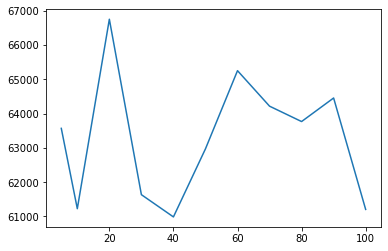

In [23]:
k_array = [100,90,80,70,60,50,40,30,20,10,5]
graph_mean=[]
for k in k_array:
    rf_LE=feature_Wrapper_RFE(X_train=LE_df.drop(drops,axis=1),y_train=LE_df.SalePrice,model=rf,n_features=k)
    #topK_mutual_mxLE = rf_feat_list[:k]
    rf_feat_list =rf_LE.to_list()
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=LE_df[topK_mutual_mxLE+['SalePrice']],target=target,model=rf,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    graph_mean.append(np.mean(RMSE_arr))

sns.lineplot(k_array,graph_mean)    
    



In [25]:
borr_df =LE_df.drop(drops,axis=1)

In [26]:
feature_Boruta(X_train_df=borr_df,X_train_values=borr_df.values, y_train_values=LE_df.SalePrice.values,model=rf)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	84
Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	84
Iteration: 	10 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	84
Iteration: 	11 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	84
Iteration: 	12 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	84
Iteration: 	13 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	84
Iteration: 	14 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	84
Iteration: 	15 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	84
Iteration: 	16 / 100
Confirmed: 	17
Tentative: 	5

Index(['LotFrontage', 'OverallQual', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'total_indoor_sqft', 'total_in_out_sqft', 'no_finishes',
       'YearBuilt_Age', 'YrSd_YrBlt', 'total_Bmt_Ql_Cd', 'total_Bmt_Fn_Area',
       'avg_Bmt_Qual', 'total_All_Qualities', 'avg_All_Qualities'],
      dtype='object')

In [32]:
feature_Boruta(X_train_df=borr_df,X_train_values=borr_df.values, y_train_values=LE_df.SalePrice.values,model=et)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	32
Rejected: 	66
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	32
Rejected: 	66
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	32
Rejected: 	66
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	32
Rejected: 	66
Iteration: 	12 / 100
Confirmed: 	17
Tentative: 	24
Rejected: 	66
Iteration: 	13 / 100
Confirmed: 	17
Tentative: 	22
Rejected: 	68
Iteration: 	14 / 100
Confirmed: 	17
Tentative: 	22
Rejected: 	68
Iteration: 	15 / 100
Confirmed: 	17
Tentative: 	22
Rejected: 	68
Iteration: 	16 / 100
Confirmed: 	23
Tentative

Index(['LotArea', 'OverallQual', 'MasVnrArea', 'ExterQual', 'BsmtQual',
       'BsmtFinSF1', 'TotalBsmtSF', 'CentralAir', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'FullBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'LotShape_LandContour', 'total_indoor_sqft',
       'total_outdoor_sqft', 'total_in_out_sqft', 'no_finishes',
       'YearBuilt_Age', 'YearRemodAdd_Age', 'YrSd_YrBlt', 'YrSd_YrRmd',
       'total_Bmt_Ql_Cd', 'total_Bmt_Fn_Area', 'avg_Bmt_Qual',
       'total_All_Qualities', 'avg_All_Qualities'],
      dtype='object')

In [27]:
borr_rf_feat= ['LotFrontage', 'OverallQual', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'total_indoor_sqft', 'total_in_out_sqft', 'no_finishes',
       'YearBuilt_Age', 'YrSd_YrBlt', 'total_Bmt_Ql_Cd', 'total_Bmt_Fn_Area',
       'avg_Bmt_Qual', 'total_All_Qualities', 'avg_All_Qualities','SalePrice']

In [33]:
borr_et_feat = ['LotArea', 'OverallQual', 'MasVnrArea', 'ExterQual', 'BsmtQual',
       'BsmtFinSF1', 'TotalBsmtSF', 'CentralAir', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'FullBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'LotShape_LandContour', 'total_indoor_sqft',
       'total_outdoor_sqft', 'total_in_out_sqft', 'no_finishes',
       'YearBuilt_Age', 'YearRemodAdd_Age', 'YrSd_YrBlt', 'YrSd_YrRmd',
       'total_Bmt_Ql_Cd', 'total_Bmt_Fn_Area', 'avg_Bmt_Qual',
       'total_All_Qualities', 'avg_All_Qualities','SalePrice']

In [38]:
borr_xgb_feat =['OverallQual', 'BsmtQual', 'BsmtFinSF1', '2ndFlrSF', 'GarageCars',
       'LotShape_LandSlope', 'total_indoor_sqft', 'total_in_out_sqft',
       'no_finishes', 'YrSd_YrBlt', 'YrSd_YrRmd', 'total_Bmt_Ql_Cd',
       'total_Bmt_Fn_Area', 'total_All_Qualities','SalePrice']

In [29]:
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=LE_df[borr_rf_feat],target=target,model=rf,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    

Fold = 0, RMSE = 22324.39121034361
Fold = 1, RMSE = 25673.310534578297
Fold = 2, RMSE = 26717.99921717522
Fold = 3, RMSE = 24980.985561964233
Fold = 4, RMSE = 24725.268004695314
k=  5  mean_score =  24884.390905751334


In [30]:
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=LE_df[borr_rf_feat],target=target,model=et,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    

Fold = 0, RMSE = 45164.09362891792
Fold = 1, RMSE = 36751.5061427916
Fold = 2, RMSE = 25836.910852665907
Fold = 3, RMSE = 21726.097165769323
Fold = 4, RMSE = 44356.333043528735
k=  5  mean_score =  34766.98816673471


In [31]:
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=LE_df[borr_rf_feat],target=target,model=xgb,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    

Fold = 0, RMSE = 45988.882963815726
Fold = 1, RMSE = 29463.411823101957
Fold = 2, RMSE = 25344.835062817114
Fold = 3, RMSE = 28312.74123637796
Fold = 4, RMSE = 28250.52106146429
k=  5  mean_score =  31472.078429515408


In [34]:
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=LE_df[borr_et_feat],target=target,model=rf,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    

Fold = 0, RMSE = 20410.550585008965
Fold = 1, RMSE = 26710.957595336513
Fold = 2, RMSE = 25742.463966143823
Fold = 3, RMSE = 33101.3841523251
Fold = 4, RMSE = 31017.497075336763
k=  5  mean_score =  27396.570674830233


In [35]:
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=LE_df[borr_et_feat],target=target,model=et,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    

Fold = 0, RMSE = 24529.765102266647
Fold = 1, RMSE = 26526.062933274443
Fold = 2, RMSE = 21241.764785029332
Fold = 3, RMSE = 47194.10443488721
Fold = 4, RMSE = 23056.805440166474
k=  5  mean_score =  28509.70053912482


In [36]:
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=LE_df[borr_et_feat],target=target,model=xgb,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    

Fold = 0, RMSE = 27969.891862204746
Fold = 1, RMSE = 24011.49620959694
Fold = 2, RMSE = 31376.572355640015
Fold = 3, RMSE = 36799.80091897245
Fold = 4, RMSE = 27737.40914408827
k=  5  mean_score =  29579.03409810049


In [37]:
feature_Boruta(X_train_df=borr_df,X_train_values=borr_df.values, y_train_values=LE_df.SalePrice.values,model=xgb)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	107
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	32
Rejected: 	64
Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	32
Rejected: 	64
Iteration: 	10 / 100
Confirmed: 	11
Tentative: 	32
Rejected: 	64
Iteration: 	11 / 100
Confirmed: 	11
Tentative: 	32
Rejected: 	64
Iteration: 	12 / 100
Confirmed: 	11
Tentative: 	23
Rejected: 	73
Iteration: 	13 / 100
Confirmed: 	11
Tentative: 	23
Rejected: 	73
Iteration: 	14 / 100
Confirmed: 	11
Tentative: 	23
Rejected: 	73
Iteration: 	15 / 100
Confirmed: 	11
Tentative: 	23
Rejected: 	73
Iteration: 	16 / 100
Confirmed: 	11
Tenta

Index(['OverallQual', 'BsmtQual', 'BsmtFinSF1', '2ndFlrSF', 'GarageCars',
       'LotShape_LandSlope', 'total_indoor_sqft', 'total_in_out_sqft',
       'no_finishes', 'YrSd_YrBlt', 'YrSd_YrRmd', 'total_Bmt_Ql_Cd',
       'total_Bmt_Fn_Area', 'total_All_Qualities'],
      dtype='object')

In [39]:
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=LE_df[borr_xgb_feat],target=target,model=rf,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    

Fold = 0, RMSE = 23071.057057028032
Fold = 1, RMSE = 43693.72052163826
Fold = 2, RMSE = 26744.522917142796
Fold = 3, RMSE = 25784.795528286373
Fold = 4, RMSE = 27964.384477043404
k=  5  mean_score =  29451.696100227768


In [41]:
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=LE_df[borr_xgb_feat],target=target,model=et,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    

Fold = 0, RMSE = 24703.98366861415
Fold = 1, RMSE = 35796.54803204698
Fold = 2, RMSE = 24670.048201160942
Fold = 3, RMSE = 26288.249145497168
Fold = 4, RMSE = 21816.801955572933
k=  5  mean_score =  26655.126200578437


In [42]:
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=LE_df[borr_xgb_feat],target=target,model=xgb,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    

Fold = 0, RMSE = 44526.97353100746
Fold = 1, RMSE = 32828.83113168881
Fold = 2, RMSE = 34360.66807778239
Fold = 3, RMSE = 33315.93547394605
Fold = 4, RMSE = 34367.37836387763
k=  5  mean_score =  35879.95731566047


In [43]:
from sklearn.ensemble import AdaBoostRegressor
ada= AdaBoostRegressor()

In [44]:
    RMSE_arr=[]
    for i in np.arange(5):
        score= run(df=LE_df[borr_xgb_feat],target=target,model=ada,fold=i,dropped=[],save_fold_csv=False)  
        RMSE_arr.append(score)
    print('k= ',k,' mean_score = ', np.mean(RMSE_arr))
    print("=========================")
    

Fold = 0, RMSE = 46665.02850202144
Fold = 1, RMSE = 36210.0316442367
Fold = 2, RMSE = 31568.747577018727
Fold = 3, RMSE = 32592.590892108386
Fold = 4, RMSE = 35131.39878127552
k=  5  mean_score =  36433.55947933216
